In [132]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import random
from scipy import stats


In [83]:
#Things to record-
#(1) Distribution of area of toppling affected by one sanddrop. 
#(2) Dsitribution of time of toppling due to one sanddrop.  
#(3) Distribution of number of topplings on adding one sanddrop. (one time step can have >1 unstable points)

In [171]:
def generate_grid(dim, z_c):              
   #Create a grid for operations
    grid_1d=np.zeros((dim + 2)*(dim + 2)*2, dtype=int)
    grid=np.reshape(grid_1d,(dim+2,dim+2,2))  # 3rd dim for marking affected blocks.
    
    # random initialisation of the grid with boundaries fixed at 0
    for i in range(1, dim+1):
        for j in range(1,dim+1):
            grid[i,j,0]=int(np.random.random()*z_c)
    grid[:,0,0]=0
    grid[0,:,0]=0
    grid[:,dim+1,0]=0
    grid[dim+1,:,0]=0
    
    print(grid[:,:,0])
    return grid


def dropsand(grid_old, dim):    # add a grain of sand to the grid
    grid=grid_old.copy()
    x=random.randint(1,dim+1)
    y=random.randint(1,dim+1)
    grid[x,y,0]=grid[x,y,0]+1
    return grid
       

def topplefunc(grid_recieved, dim, unstable_sites):     # to topple the sites after noting down the unstable ones.
    grid=grid_recieved.copy()
    # resetting the affected sites
    for x in unstable_sites:
        grid[x[0],x[1],0]=grid[x[0],x[1],0]-4
        grid[x[0],x[1]+1,0]=grid[x[0],x[1]+1,0]+1
        grid[x[0]+1,x[1],0]=grid[x[0]+1,x[1],0]+1
        grid[x[0],x[1]-1,0]=grid[x[0],x[1]-1,0]+1
        grid[x[0]-1,x[1],0]=grid[x[0]-1,x[1],0]+1
        grid[x[0],x[1],1]=1
        grid[x[0],x[1]+1,1]=1
        grid[x[0]+1,x[1],1]=1
        grid[x[0],x[1]-1,1]=1
        grid[x[0]-1,x[1],1]=1
        
    # resetting boundaries to 0
    grid[:,0,0]=0
    grid[0,:,0]=0
    grid[:,dim+1,0]=0
    grid[dim+1,:,0]=0
    grid[:,0,1]=0
    grid[0,:,1]=0
    grid[:,dim+1,1]=0
    grid[dim+1,:,1]=0
    
    # return the updated grid which has been toppled and has affected areas marked.
    return grid.copy()
    

def count_area(grid, time):    # returning the number of blocks affected
    counter=0
    for i in range(1, dim+1):
        for j in range(1, dim+1):
            if(grid[i,j,1]==1):
                counter=counter+1
    return counter


def count_topple(list):       # return the sum of elements of the "no_of_unstable_sites" list.
    sum=0
    for n in list:
        sum=sum+n
    return sum

def count_time(list):        # the number of elements appended to "no_of_unstable_sites" is a direct measure of relax time.
    time=len(list)-1         # we subtract 1 because the while loop runs an extra iteration
    return time
    
def updategrid(grid_old, dim, z_c):
    grid=grid_old.copy()
    grid[:,:,1]=0                  # resetting the affected sites to null
    unstable=1                     # initially, we set unstability factor to 1 implying True.
    no_of_unstable_sites=[]
    
    while(unstable!=0):            # while unstability doesn't turn to False.
        unstable_sites=[]
        for i in range(1,dim+1):
            for j in range(1,dim+1):
                if(grid[i,j,0]>=z_c):
                    unstable_sites.append([i,j])     # noting down the unstable points at time step t
        
        unstable=len(unstable_sites)                 # as soon as there are 0 unstable points, we exit the while loop.
        no_of_unstable_sites.append(unstable)        # appending number of unstable sites. sum them to get total topplings.
        
        grid=topplefunc(grid, dim, unstable_sites)
    # ------while loop ends-----
    
    area=count_area(grid, dim)
    topples=count_topple(no_of_unstable_sites)
    relaxtime=count_time(no_of_unstable_sites)
    
    return grid.copy(),area,topples,relaxtime
    
# Functions for Data Analysis
def filter_func(list):
    new_list=[]
    for i in range(len(list)):
        if (list[i]!=0):
            new_list.append(list[i])
    return new_list


def binned_data(area_ub, topples_ub, relaxtime_ub):
    n=int(np.sqrt(len(filter_func(area_ub))))  # number of bins
    
    # binning the data 
    area=np.histogram(filter_func(area_ub), n)[0]
    topples=np.histogram(filter_func(topples_ub), n)[0]
    relaxtime=np.histogram(filter_func(relaxtime_ub), n)[0]
    bin_og=np.histogram(filter_func(area_ub), n)[1]
    
    bins=[]
    for i in range(len(bin_og)-1):
        bins.append((bin_og[i]+bin_og[i+1])/2)   # averaged bins 
        
    return area, topples, relaxtime, bins


def plot(data_old, bins_old, perc, string, colour,dim,time_steps):
    bins=[]
    data=[]
    for i in range(len(data_old)):
        if (data_old[i]!=0):
            data.append(data_old[i])
            bins.append(bins_old[i])
    # "bins" and "data" now only contain non-zero entries
    
    m,c,delta_m=lq_fit(data,bins, perc)
    fig = plt.figure()
    y=[c,0]
    x=(y-c)/m
    
    plt.plot(x,y,'black')
    plt.plot(np.log(bins),np.log(data), 'o', color=colour)
    plt.grid(True)
    plt.legend(loc="center left")
    plt.xlabel("log(" + string + ")")
    plt.ylabel("log(occurences of " + string + ")")
    ax = fig.add_subplot(111)
    ax.text(0.1*c,0.1*c,"m = " + str(round(m,3)) + " ,dm = " + str(round(delta_m,3)) ,color='black', fontsize=10)
    plt.savefig('PLOT ' + string + ' dim ' + str(dim) + 'x' + str(dim) + ' time steps= ' + str(time_steps)  + '.png', dpi=(250))  
    plt.show()


def lq_fit(data,bins,perc):
    x=[]
    y=[]
    for i in range(int(len(data)*perc*0.01)):
        x.append(bins[i])
        y.append(data[i])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x),np.log(y))
    
    return slope, intercept, std_err
        

In [191]:
dim=50
z_c=4
time_steps=1000
area_list=[]
topples_list=[]
relaxtime_list=[]
grid=generate_grid(dim, z_c)
start = timer()

# evolving the grid in time t
for t in range(time_steps):
    grid_sanddrop= dropsand(grid, dim)
    grid,area,topples,relaxtime=updategrid(grid_sanddrop, dim, z_c)
    
    area_list.append(area)
    topples_list.append(topples)
    relaxtime_list.append(relaxtime)
    if(t%1000==0):
        print(t)
    
end = timer()
print("Runtime= ", end-start, " secs")

[[0 0 0 ... 0 0 0]
 [0 2 1 ... 0 0 0]
 [0 1 0 ... 1 1 0]
 ...
 [0 0 3 ... 3 3 0]
 [0 0 3 ... 2 0 0]
 [0 0 0 ... 0 0 0]]
0
1000
2000
3000
4000


KeyboardInterrupt: 

No handles with labels found to put in legend.
C:\Users\kunal\anaconda3\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


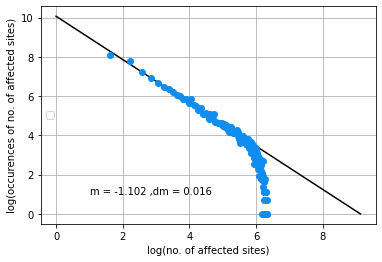

No handles with labels found to put in legend.
C:\Users\kunal\anaconda3\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


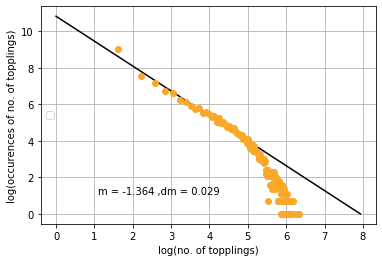

No handles with labels found to put in legend.
C:\Users\kunal\anaconda3\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


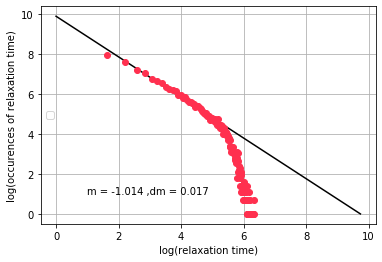

In [190]:
area, topples, relaxtime, bins= binned_data(area_list, topples_list, relaxtime_list)
perc=35                   #what percent of initial data bins do you want to fit for lsq fit. only 35% of initial datapoints from the bin are analysed
plot(area,bins,perc,"no. of affected sites","#118df0",dim,time_steps)
plot(topples,bins,perc, "no. of topplings", "#f9a828",dim,time_steps)
plot(relaxtime,bins,perc, "relaxation time", "#ff304f",dim,time_steps)

